In [1]:
import torch
from modeling.neighborhoods import LocalNeighborhood

/home/megvii/anaconda3/envs/paul-py3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coordinates=['index_distance']
config = None
nei_layer = LocalNeighborhood(
    config, Kmax=14, coordinates=coordinates, self_neighborhood=True)

bs = 2
s1 = 256
h = 32
indices = torch.arange(s1).repeat(bs, 1).unsqueeze(dim=-1)
feat1 = torch.rand(bs, s1, h)
feat2 = torch.rand(bs, s1, h)
inputs = [indices, feat1, feat2]
output = nei_layer(inputs)

neighbor_coordinates size=1


In [3]:
for it in output:
    for iit in it:
        print(iit.shape)

torch.Size([2, 256, 14, 1])
torch.Size([256, 14, 32])
torch.Size([256, 14, 32])
torch.Size([256, 14, 32])
torch.Size([256, 14, 32])


In [10]:
output[0][0].shape

torch.Size([2, 256, 14, 1])

In [14]:
import torch.nn as nn
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)

output, hn = rnn(input)
output.shape, hn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

In [15]:
x1 = torch.randn(5, 3, 10)
x2 = torch.randn(5, 3, 10)
torch.cat([x1, x2],dim=-1).shape

torch.Size([5, 3, 20])

In [18]:
import torch.nn as nn

class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [20]:
# torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
dense = nn.Linear(20, 32, bias=False)
seq_net = TimeDistributed(dense, batch_first=True)

x1 = torch.randn(5, 3, 20)
y = seq_net(x1)
y.shape

torch.Size([5, 3, 32])

In [26]:
from modeling.lib import GlobalGraph

inputs = torch.rand(2, 10, 64)
mask = torch.ones([2,10,10])

gnet = GlobalGraph(64)
output = gnet(inputs, mask)
output.shape

torch.Size([2, 10, 64])

In [36]:
# tf.gather_nd(points, triplets[:, :, 1:2], batch_dims=1)
points = torch.rand(2,10,3)
triplets = torch.randint(0, 10, (2,5,3))
offsets = (torch.arange(2) * 10).reshape(2,1,1)

indices = triplets[:,:,1:2]
print(indices)
indices = indices + offsets
print(indices)


tensor([[[2],
         [0],
         [5],
         [5],
         [2]],

        [[3],
         [0],
         [1],
         [3],
         [4]]])
tensor([[[ 2],
         [ 0],
         [ 5],
         [ 5],
         [ 2]],

        [[13],
         [10],
         [11],
         [13],
         [14]]])


In [42]:
import numpy as np
batch_dim =3
batch_size = 5
params = torch.randn(batch_size, batch_size, batch_size, 4, 4, 4, 32)
indices = torch.randint(4, (batch_size, batch_size, batch_size, 12, 3))

batch_dims = params.size()[:batch_dim]  # [b1, ..., bn]
batch_size = np.cumprod(list(batch_dims))[-1]  # b1 * ... * bn
c_dim = params.size()[-1]  # c
grid_dims = params.size()[batch_dim:-1]  # [g1, ..., gm]
n_indices = indices.size(-2)  # x
n_pos = indices.size(-1)  # m

# reshape leadning batch dims to a single batch dim
params = params.reshape(batch_size, *grid_dims, c_dim)
indices = indices.reshape(batch_size, n_indices, n_pos)

batch_enumeration = torch.arange(batch_size).unsqueeze(1)
gather_dims = [indices[:, :, i] for i in range(len(grid_dims))]
gather_dims.insert(0, batch_enumeration)




torch.Size([125, 4, 4, 4, 32])

In [64]:
params = torch.rand(2, 5, 2)
print(params)
batch_dim = torch.arange(2).unsqueeze(1).unsqueeze(1)
dim2 = torch.tensor([ [[0,1,2], [1,2,3]], [[2,3,4], [2,3,4]] ])
dims = [batch_dim, dim2]
params[dims], params[dims].shape

tensor([[[0.6688, 0.5033],
         [0.9680, 0.8551],
         [0.5141, 0.1596],
         [0.1239, 0.5980],
         [0.9618, 0.2434]],

        [[0.4828, 0.1921],
         [0.5933, 0.6344],
         [0.5788, 0.8869],
         [0.3521, 0.6423],
         [0.8749, 0.6521]]])


(tensor([[[[0.6688, 0.5033],
           [0.9680, 0.8551],
           [0.5141, 0.1596]],
 
          [[0.9680, 0.8551],
           [0.5141, 0.1596],
           [0.1239, 0.5980]]],
 
 
         [[[0.5788, 0.8869],
           [0.3521, 0.6423],
           [0.8749, 0.6521]],
 
          [[0.5788, 0.8869],
           [0.3521, 0.6423],
           [0.8749, 0.6521]]]]),
 torch.Size([2, 2, 3, 2]))

In [77]:
sz1 = torch.Size([5 for _ in range(2)])
sz2 = torch.Size([1 for _ in range(2)])
x = torch.rand(25,1)
x.reshape(*sz1, *sz2, 1).shape

torch.Size([5, 5, 1, 1, 1])

In [3]:
import torch
from neighborhoods import gather_nd_torch_ex

In [5]:
params = torch.rand(2,4,4,3)
indices = torch.randint(4,(2,6,3,2))
out = gather_nd_torch_ex(params,indices,1)
out.shape

torch.Size([2, 6, 3, 3])

In [14]:
x = torch.tensor([[1,0,0], [1,0,0]]) # (2,3)
x = x.expand(4,2,3)
y = torch.tensor([[0,-1,0], [1,0,0], [0,0,1]]) # (3,3)
y = y.expand(2,3,3)

torch.tensordot(x,y, ([-1], [-1])).shape

torch.Size([4, 2, 2, 3])

In [8]:
import pandas as pd
df = pd.read_csv('data/test/test.csv',sep='\t')
df.head(10)

,dataset_id,UniProt,protein_sequence,nucleotide_sequence,protein_mutation,nucleic_acid_type,Kd,dG,pH,Tm,...,max_min,max_min_judge,dG_ori,pdb_id,len_p1,len_p2,protein_chain,na_chain,identity_protein_seq,identity_na_seq
0,pnat_2082,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACATC|GATGTTGGTTGGACGGCTGC...,Y271S,dsDNA,0.2,-0.98,7.7,310.0,...,1.41,bigger_1,-0.99,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,pnat_8413,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACTCA|TGAGTTGGTTGGACGGCTGC...,Y271S,dsDNA,0.041,-0.99,7.7,310.0,...,1.96,bigger_1,-1.97,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,pronab_6471,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACATC|GGACGGCATTGGATCGACCA...,Y271A,DNA,0.314,-0.71,7.7,310.0,...,0.00,good,-0.71,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,pnat_9619,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACATC|GATGTTGGTTGGACGGCTGC...,N279A,dsDNA,0.2,-0.98,7.7,310.0,...,1.41,bigger_1,-0.99,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,pnat_12423,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACTCA|TGAGTTGGTTGGACGGCTGC...,Y271A,dsDNA,0.98,-0.99,7.7,310.0,...,1.96,bigger_1,-0.01,NONE,NONE,NONE,NONE,NONE,NONE,NONE
5,pnat_799,P36068,MSKDKDIKVTPGTCELVEQILALLSRYLSSYIHVLNKFISHLRRVA...,GAUAACUGAAUCGAAAGACAUUAUCACG,wild,RNA,0.26,-0.80,NONE,NONE,...,0.00,good,-0.80,5m0i,"D:235,C:240,B:238,A:225,H:8,J:7,I:7","E:28,F:28",A_1.B_1.C_1.D_1.H_1.I_1.J_1,E_1.F_1,0.03,0.5
6,pronab_6481,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACATC|GGACGGCATTGGATCGACCA...,wild,DNA,0.2,-0.99,7.7,310.0,...,0.00,good,-0.99,NONE,NONE,NONE,NONE,NONE,NONE,NONE
7,pronab_6683,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACTCA|GGACGGCATTGGATCGAGGA...,Y271S,DNA,0.023,-1.40,7.7,310.0,...,1.84,bigger_1,-2.32,NONE,NONE,NONE,NONE,NONE,NONE,NONE
8,pnat_12656,P18146,MAAAKAEMQLMSPLQISDPFGSFPHSPTMDNYPKLEEMMLLSNGAP...,GTGTGGGCT|AGCCCACAC,wild,dsDNA,NONE,-0.06,7.5,293.0,...,0.00,good,-0.06,4r2a,A:86,"B:10,C:10",A_1,B_1.C_1,0.14,0.37
9,pnat_3681,P06766,MSKRKAPQETLNGGITDMLVELANFEKNVSQAIHKYNAYRKAASVI...,GCCTCGCAGCCGTCCAACCAACTCA|TGAGTTGGTTGGACGGCTGC...,Y271F,dsDNA,0.98,-0.99,7.7,310.0,...,1.96,bigger_1,-0.01,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [1]:
from preprocessing.protein_chemistry import list_aa, \
  aa_to_index, dictionary_covalent_bonds, list_atoms, atom_type_mass, \
  nucleotide_to_index

In [3]:
max_len = 0
lengths = []
for k, v in dictionary_covalent_bonds.items():
    lengths.append(len(v.keys()))
max(lengths), lengths

(15, [6, 7, 9, 10, 12, 5, 11, 9, 10, 9, 9, 9, 8, 10, 12, 7, 8, 8, 15, 13])

In [26]:
import torch
import numpy as np
import torch.nn as nn
from modeling.lib import MLP, GlobalGraph

In [8]:
realxs = []
lengths = []
for i in range(5):
    n = int(np.random.randint(1,5,1))
    lengths.append(n)
    realxs.append(torch.rand(n, 1))
print(lengths)
xs = torch.zeros([5, max(lengths), 1])
for i in range(5):
    xs[i, :lengths[i]] = realxs[i]
print(xs)

[4, 3, 2, 4, 3]
tensor([[[0.0998],
         [0.4803],
         [0.1310],
         [0.4313]],

        [[0.8018],
         [0.8982],
         [0.5441],
         [0.0000]],

        [[0.4427],
         [0.5312],
         [0.0000],
         [0.0000]],

        [[0.4554],
         [0.0222],
         [0.0872],
         [0.4144]],

        [[0.5823],
         [0.5139],
         [0.8875],
         [0.0000]]])


In [33]:
fc = nn.Linear(1, 4, bias=False)
ys = fc(xs)
print(ys.shape, ys)

torch.Size([5, 4, 4]) tensor([[[ 0.0707, -0.0846,  0.0357, -0.0533],
         [ 0.3401, -0.4074,  0.1717, -0.2565],
         [ 0.0928, -0.1111,  0.0468, -0.0700],
         [ 0.3054, -0.3659,  0.1542, -0.2304]],

        [[ 0.5677, -0.6802,  0.2867, -0.4283],
         [ 0.6360, -0.7620,  0.3211, -0.4798],
         [ 0.3852, -0.4615,  0.1945, -0.2906],
         [ 0.0000, -0.0000,  0.0000, -0.0000]],

        [[ 0.3135, -0.3756,  0.1583, -0.2365],
         [ 0.3761, -0.4506,  0.1899, -0.2837],
         [ 0.0000, -0.0000,  0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000, -0.0000]],

        [[ 0.3225, -0.3863,  0.1628, -0.2433],
         [ 0.0157, -0.0189,  0.0080, -0.0119],
         [ 0.0617, -0.0740,  0.0312, -0.0466],
         [ 0.2934, -0.3515,  0.1481, -0.2213]],

        [[ 0.4123, -0.4940,  0.2082, -0.3110],
         [ 0.3639, -0.4359,  0.1837, -0.2745],
         [ 0.6284, -0.7529,  0.3173, -0.4740],
         [ 0.0000, -0.0000,  0.0000, -0.0000]]], grad_fn=<UnsafeViewBackward>

In [31]:
gg = GlobalGraph(4, num_attention_heads=2)
attention_mask = torch.zeros([5, 4, 4])
for i in range(5):
    assert lengths[i] > 0
    attention_mask[i, :lengths[i], :lengths[i]].fill_(1)

In [35]:
out = gg(ys, attention_mask)
out

tensor([[[ 0.2705,  0.3876, -0.2330, -0.0214],
         [ 0.2707,  0.3877, -0.2325, -0.0220],
         [ 0.2705,  0.3876, -0.2329, -0.0215],
         [ 0.2707,  0.3877, -0.2325, -0.0219]],

        [[ 0.4991,  0.4248, -0.0778, -0.2200],
         [ 0.4991,  0.4248, -0.0777, -0.2201],
         [ 0.4989,  0.4248, -0.0781, -0.2197],
         [ 0.3979,  0.4083, -0.1342, -0.1478]],

        [[ 0.3719,  0.4041, -0.1675, -0.1051],
         [ 0.3719,  0.4041, -0.1675, -0.1052],
         [ 0.2470,  0.3838, -0.2449, -0.0061],
         [ 0.2470,  0.3838, -0.2449, -0.0061]],

        [[ 0.2501,  0.3843, -0.2455, -0.0054],
         [ 0.2497,  0.3842, -0.2462, -0.0045],
         [ 0.2498,  0.3843, -0.2461, -0.0046],
         [ 0.2500,  0.3843, -0.2455, -0.0053]],

        [[ 0.4559,  0.4178, -0.1067, -0.1831],
         [ 0.4559,  0.4178, -0.1067, -0.1830],
         [ 0.4561,  0.4178, -0.1063, -0.1836],
         [ 0.3676,  0.4034, -0.1574, -0.1182]]], grad_fn=<ViewBackward>)

In [13]:
att = torch.zeros(1, 8, 8)
# att[0][:4][:4].fill_(1)
att[0,:4,:4].fill_(1)
# att[0][0][:4].fill_(1)
# att[0][1][:4].fill_(1)
print(att)

tensor([[[1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])


In [6]:
from axial_positional_embedding import AxialPositionalEmbedding

max_seq_len = 1000

axial_position_shape = default(axial_position_shape, (math.ceil(max_seq_len / 64), 64))
pos_emb = AxialPositionalEmbedding(dim, axial_position_shape)

NameError: name 'default' is not defined

In [14]:
math.ceil(16 / 64)

1

In [12]:
import torch
import math
from axial_positional_embedding import AxialPositionalEmbedding
max_seq_len = 1024

pos_emb = AxialPositionalEmbedding(
    dim = 512,
    axial_shape = (math.ceil(max_seq_len / 64), 64)
)

tokens = torch.randn(22, 1024, 512)  # assume are tokens
tokens = pos_emb(tokens) + tokens   # add positional embedding to token embeddings
tokens.shape

torch.Size([22, 1024, 512])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
 
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=6, n=100)
print(P)

[[ 0.          1.          0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.21378067  0.97688169  0.04639922  0.99892298]
 [ 0.90929743 -0.41614684  0.41767683  0.90859565  0.0926985   0.99569422]
 [ 0.14112001 -0.9899925   0.60226103  0.79829922  0.1387981   0.9903207 ]]


In [11]:
import torch.nn.functional as F
from torch import nn, Tensor

x = torch.rand(2,3)
y = torch.rand(2,3)
reg_loss = nn.SmoothL1Loss(reduction="sum")
reg_loss(x, y)

m = nn.Dropout(p=0.2)
input = torch.randn(20, 12, 16)
output = m(input)
output.shape

torch.Size([20, 12, 16])

In [21]:
ctrs = torch.rand(2,4)
print(ctrs)

gt_logics = torch.tensor([2, 0], dtype=torch.int64)
inds1 = torch.arange(gt_logics.shape[0])
ctrs[inds1, gt_logics]

tensor([[0.8830, 0.3177, 0.4118, 0.2479],
        [0.8446, 0.8171, 0.3588, 0.2595]])


tensor([0.4118, 0.8446])

初始化的学习率： 0.1
第1个epoch的学习率：0.100000
第2个epoch的学习率：0.099384
第3个epoch的学习率：0.097553
第4个epoch的学习率：0.094550
第5个epoch的学习率：0.090451
第6个epoch的学习率：0.085355
第7个epoch的学习率：0.079389
第8个epoch的学习率：0.072700
第9个epoch的学习率：0.065451
第10个epoch的学习率：0.057822
第11个epoch的学习率：0.050000
第12个epoch的学习率：0.042178
第13个epoch的学习率：0.034549
第14个epoch的学习率：0.027300
第15个epoch的学习率：0.020611
第16个epoch的学习率：0.014645
第17个epoch的学习率：0.009549
第18个epoch的学习率：0.005450
第19个epoch的学习率：0.002447
第20个epoch的学习率：0.000616
第21个epoch的学习率：0.000000
第22个epoch的学习率：0.000616
第23个epoch的学习率：0.002447
第24个epoch的学习率：0.005450
第25个epoch的学习率：0.009549
第26个epoch的学习率：0.014645
第27个epoch的学习率：0.020611
第28个epoch的学习率：0.027300
第29个epoch的学习率：0.034549
第30个epoch的学习率：0.042178
第31个epoch的学习率：0.050000
第32个epoch的学习率：0.057822
第33个epoch的学习率：0.065451
第34个epoch的学习率：0.072700
第35个epoch的学习率：0.079389
第36个epoch的学习率：0.085355
第37个epoch的学习率：0.090451
第38个epoch的学习率：0.094550
第39个epoch的学习率：0.097553
第40个epoch的学习率：0.099384
第41个epoch的学习率：0.100000
第42个epoch的学习率：0.099384
第43个epoch的学习率：0.097553
第44个epo

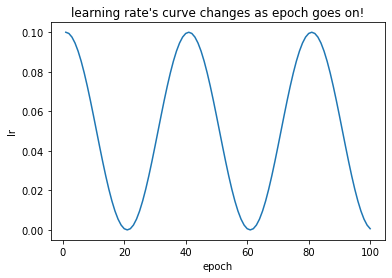

In [12]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import itertools

import matplotlib.pyplot as plt


initial_lr = 0.1

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)

    def forward(self, x):
        pass

net_1 = model()

optimizer_1 = torch.optim.Adam(net_1.parameters(), lr = initial_lr)
scheduler_1 = CosineAnnealingLR(optimizer_1, T_max=20, eta_min=0.0001)

print("初始化的学习率：", optimizer_1.defaults['lr'])

lr_list = [] # 把使用过的lr都保存下来，之后画出它的变化

for epoch in range(1, 101):
    # train

    optimizer_1.zero_grad()
    optimizer_1.step()
    print("第%d个epoch的学习率：%f" % (epoch, optimizer_1.param_groups[0]['lr']))
    lr_list.append(optimizer_1.param_groups[0]['lr'])
    scheduler_1.step()

# 画出lr的变化
plt.plot(list(range(1, 101)), lr_list)
plt.xlabel("epoch")
plt.ylabel("lr")
plt.title("learning rate's curve changes as epoch goes on!")
plt.show()